## Setup

In [1]:
#include <xtensor/xarray.hpp>    // xarrays!
#include <xtensor/xview.hpp>     // slice the image arrays into color channels
#include <xtensor/xbuilder.hpp>  // xt::stack

#include <xtensor-io/ximage.hpp> // for loading images

#include <xtensor-fftw/basic.hpp>  // rfft2, irfft2
#include <xtensor-fftw/helper.hpp> // (r)fftscale
#include <complex>                 // for i = sqrt(-1)

// for displaying images (see xtensor-io and xeus-cling demos)
#include <string>
#include <fstream>
#include <xtl/xbase64.hpp>

#include "nlohmann/json.hpp"

namespace nl = nlohmann;

In [3]:
template <class E>
auto display(const xt::xexpression<E>& e, xeus::xguid id = xeus::xguid(), bool update = false)
{
    xt::dump_image("/tmp/xio_image.png", e);
    std::ifstream fin("/tmp/xio_image.png", std::ios::binary);
    std::stringstream buffer;
    buffer << fin.rdbuf();

    nl::json mime;
    mime["image/png"] = xtl::base64encode(buffer.str());
    nl::json transient;

    if (update)
    {
        transient["display_id"] = id;
        xeus::get_interpreter().update_display_data(
            std::move(mime),
            nl::json::object(),
            std::move(transient));
        return id;
    }
    else
    {
        id = xeus::new_xguid();
        transient["display_id"] = id;
        xeus::get_interpreter().display_data(
            std::move(mime),
            nl::json::object(),
            std::move(transient));
        return id;
    }
}

## Intense cat

Let's perform some Fourier space operations on [this public domain, intense kitty](https://commons.wikimedia.org/wiki/File:Intensity_image_with_gradient_images.png):

In [4]:
auto image_uchar = xt::load_image("images/intense_cat.png");
xt::xarray<double> image = xt::cast<double>(image_uchar);

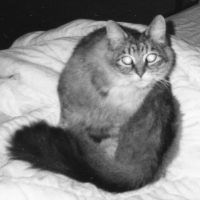

In [5]:
auto display_id = display(image_uchar);

## Edge detection on intensity image

We're going to use FFT to do some simple edge detection. To simplify, we do this on the black and white "intensity" image. In this case, the kitty is already black and white, but in fact it's still encoded in three RGB channels in the PNG file. Combining these, in general, could be done as follows:

In [6]:
xt::xarray<double> image_R = xt::view(image, xt::all(), xt::all(), 0);
xt::xarray<double> image_G = xt::view(image, xt::all(), xt::all(), 1);
xt::xarray<double> image_B = xt::view(image, xt::all(), xt::all(), 2);

In [7]:
xt::xarray<double> image_bw = (0.25*image_R + 0.5*image_G + 0.25*image_B);

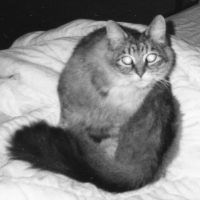

In [8]:
display(xt::cast<unsigned char>(xt::stack(xt::xtuple(image_bw, image_bw, image_bw), 2)));

Indeed, this looks exactly like the full "RGB" version above, but for general color pictures it won't.

Next, we transform to Fourier space using _xtensor-fftw_'s real FFT transform:

In [9]:
auto image_fs_bw = xt::fftw::rfft2(image_bw);

The simplest way to do some edge detection is by calculating the derivative of the intensity image. The derivative (the rate of change) is high where a sharp transition from low to high intensity occurs between two pixels, close to zero when there is little change and highly negative for high to low transition.

The derivative of an image can be calculated by multiplying the Fourier transform of the image by $\sqrt{-1} \boldsymbol{k} = i \boldsymbol{k}$ and then transforming the result back to real space. This must be done in each direction and then the results can be combined to get the magnitude of the gradient, which is a good multi-directional proxy for both kinds of edges (intensity transitions form low to high and from high to low).

In [10]:
std::complex<double> i {0, 1};
auto ky = xt::fftw::rfftscale<double>(image.shape()[1]);
auto kx = xt::fftw::fftscale<double>(image.shape()[0]);
auto kx_bc = xt::view(kx, xt::all(), xt::newaxis()); // N.B.: we use broadcasting to multiply in the right direction

In [11]:
// do both derivatives separately
xt::xarray< std::complex<double> > d_image_dx_fs_bw = xt::eval(i * kx_bc * image_fs_bw);
xt::xarray< std::complex<double> > d_image_dy_fs_bw = xt::eval(i * ky * image_fs_bw);

In [12]:
// transform back to normal space
auto d_image_dx_bw = xt::fftw::irfft2(d_image_dx_fs_bw);
auto d_image_dy_bw = xt::fftw::irfft2(d_image_dy_fs_bw);

In [13]:
// and square-sum them in real space to get the gradient magnitude
auto d_image_grad_bw = xt::sqrt(d_image_dx_bw * d_image_dx_bw + d_image_dy_bw * d_image_dy_bw);
// make it into three channels again to fool our display function that expects three channels
auto d_image_grad_bw3 = xt::stack(xt::xtuple(d_image_grad_bw, d_image_grad_bw, d_image_grad_bw), 2);

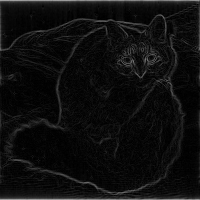

(xtl::xbasic_fixed_string<char, 55, string_policy::silent_error, char_traits<char> >) @0x7feba0a17350


In [15]:
display(xt::cast<unsigned char>(d_image_grad_bw3))

To get maximum contrast, rescale so that the maximum is 255 (the maximum brightness value, i.e. bright white):

In [18]:
double amax_d_image_grad_bw3 = xt::eval(xt::amax(d_image_grad_bw3))[0];

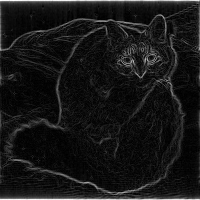

(xtl::xbasic_fixed_string<char, 55, string_policy::silent_error, char_traits<char> >) @0x7feba1adfea0


In [16]:
display(xt::cast<unsigned char>(d_image_grad_bw3 / amax_d_image_grad_bw3 * 255))

## Rescaling

To inspect the separate horizontal and vertical components, we need to rescale the range of derivative values so that they all fit into the [0,255] range of the RGB space. We subtract the minimum to set negative values to zero and then divide by (max-min) and multiply by 255 to set the maximum to 255 (and scale all intermediate values accordingly).

We can then also sum the both components to get a slightly different perspective on the above "absolute" multi-directional edge detector.

In [19]:
xt::xarray<double> d_image_dx_bw_rescale, d_image_dy_bw_rescale, d_image_grad_bw_rescale;

In [20]:
d_image_dx_bw_rescale = 255 * (d_image_dx_bw - xt::eval(xt::amin(d_image_dx_bw))[0]) / (xt::eval(xt::amax(d_image_dx_bw))[0] - xt::eval(xt::amin(d_image_dx_bw))[0]);
d_image_dy_bw_rescale = 255 * (d_image_dy_bw - xt::eval(xt::amin(d_image_dy_bw))[0]) / (xt::eval(xt::amax(d_image_dy_bw))[0] - xt::eval(xt::amin(d_image_dy_bw))[0]);

d_image_grad_bw_rescale = xt::sqrt(d_image_dx_bw_rescale * d_image_dx_bw_rescale + d_image_dy_bw_rescale * d_image_dy_bw_rescale);
d_image_grad_bw_rescale -= xt::eval(xt::amin(d_image_grad_bw_rescale))[0];
d_image_grad_bw_rescale /= xt::eval(xt::amax(d_image_grad_bw_rescale))[0];
d_image_grad_bw_rescale *= 255;

### Horizontal

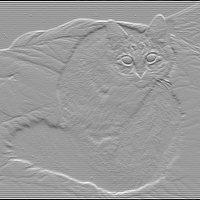

In [21]:
display(xt::cast<unsigned char>(xt::stack(xt::xtuple(d_image_dx_bw_rescale, d_image_dx_bw_rescale,
                                                     d_image_dx_bw_rescale), 2)));

### Vertical

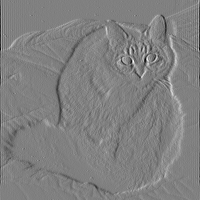

In [24]:
display(xt::cast<unsigned char>(xt::stack(xt::xtuple(d_image_dy_bw_rescale, d_image_dy_bw_rescale,
                                                     d_image_dy_bw_rescale), 2)));

The result differs slightly from that in [the original Wikipedia image](https://commons.wikimedia.org/wiki/File:Intensity_image_with_gradient_images.png), which is because their gradient function is a bit different. Their matrix gradient method smoothes the image a bit, leading to slightly less sharp edges, but also less sensitivity to noise in the image.

### Combined

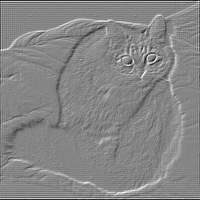

In [23]:
display(xt::cast<unsigned char>(xt::stack(xt::xtuple(d_image_grad_bw_rescale, d_image_grad_bw_rescale,
                                                     d_image_grad_bw_rescale), 2)));